In [ ]:
import os
import sys
import numpy as np
from graph_tool.all import triangulation, label_components
import hdbscan
import graph_tool
import matplotlib.pyplot as plt
from scipy.linalg import norm
import shapely
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from HierarchicalGeoClustering.TreeClusters import *
from HierarchicalGeoClustering.Clustering import *
import warnings
warnings.filterwarnings('ignore')

In [ ]:

HGC = TreeClusters(4, random_seed= 124)
HGC.populate_tree(number_per_cluster=60, avoid_intersec= True)
original_points= HGC.get_points_tree()
X_2=np.array([[p.x,p.y] for p in original_points])
dic_points={'points':[X_2], 'parent':''}
res_AMOEBA_clus, noise = compute_AMOEBA(X_2, return_noise = True)

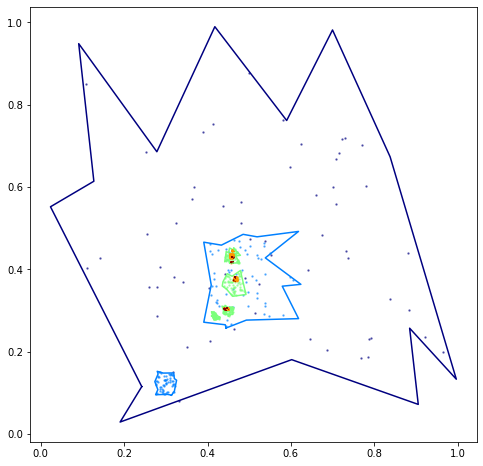

In [ ]:
fig, axs = plt.subplots( figsize=(8,8))
HGC.visualize(axs, polygon=True)

In [ ]:
 tree_AMOEBA = recursive_clustering_tree(dic_points,
                                         algorithm = 'amoeba',  # Algorithm to use
                                         return_noise = True,
                                         levels_clustering= 5,
                                                # verbose = True
                                                )

In [ ]:
len(tree_AMOEBA.get_points_tree())

1380

In [ ]:
len(X_2)

1380

In [ ]:
 tree_Natural = recursive_clustering_tree(dic_points,
                                         algorithm = 'natural_cities',  # Algorithm to use
                                         return_noise = True,
                                         levels_clustering= 5,
                                                # verbose = True
                                                )

In [ ]:
cluster_tree_AMOEBA = []
recursive_clustering([dic_points],  # Dictionary with Points
                4,  # levels to process
                cluster_tree_AMOEBA,  # to store the clusters
                level=0,  # current level
                algorithm= 'amoeba',
                return_noise = True,
                )

In [ ]:
cluster_tree_Natural  = []
recursive_clustering([dic_points],  # Dictionary with Points
                4,  # levels to process
                cluster_tree_Natural,  # to store the clusters
                level=0,  # current level
                algorithm= 'natural_cities',
                return_noise = True,
                )

In [ ]:
tree_clus_natural= get_tree_from_clustering(cluster_tree_Natural )

In [ ]:
tree_clus_AMOEBA= get_tree_from_clustering(cluster_tree_AMOEBA )

In [ ]:
tree_from_clus_AMOEBA= TreeClusters()
tree_from_clus_AMOEBA.levels_nodes = tree_clus_AMOEBA
tree_from_clus_AMOEBA.root= tree_from_clus_AMOEBA.levels_nodes[0][0]   

In [ ]:
len(tree_from_clus_AMOEBA.get_points_tree())

1380

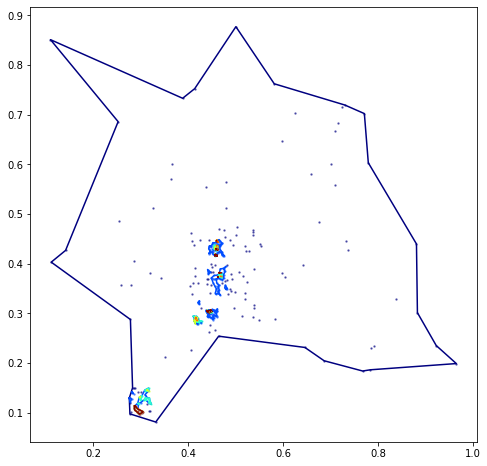

In [ ]:
fig, axs = plt.subplots( figsize=(8,8))
tree_Natural.visualize(axs, polygon=True)

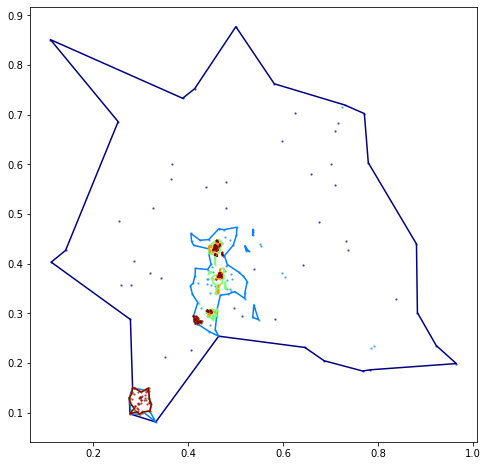

In [ ]:
fig, axs = plt.subplots( figsize=(8,8))
tree_from_clus_AMOEBA.visualize(axs, polygon=True)

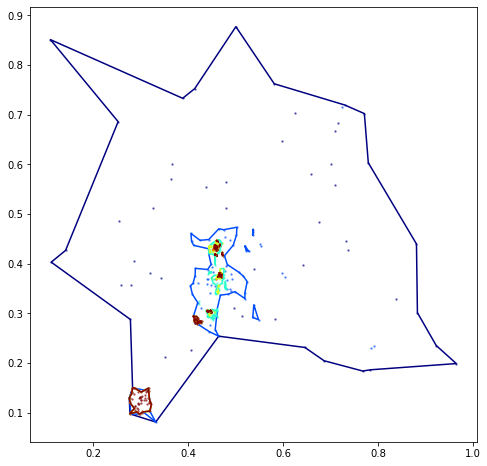

In [ ]:
fig, axs = plt.subplots( figsize=(8,8))
tree_AMOEBA.visualize(axs, polygon=True)


In [ ]:
compute_AMOEBA(X_2,
                return_noise = True,

              )

([array([[0.39018715, 0.79645148],
         [0.43816238, 0.78565631],
         [0.36411472, 0.81573224],
         ...,
         [0.45660224, 0.77384186],
         [0.45663212, 0.77383865],
         [0.45660196, 0.7738388 ]]),
  array([[0.18076925, 0.16931278],
         [0.16927816, 0.23091411],
         [0.23868285, 0.25979621],
         [0.15779684, 0.20445186],
         [0.17348815, 0.22967259],
         [0.14984659, 0.24593312],
         [0.17984877, 0.23804687],
         [0.1430899 , 0.25311699],
         [0.19645287, 0.19268892],
         [0.22720513, 0.27651094],
         [0.18460832, 0.19389642],
         [0.24521223, 0.26473689],
         [0.18984732, 0.22305362],
         [0.15545943, 0.21928903],
         [0.20891402, 0.23667461],
         [0.1810431 , 0.24941508],
         [0.16900158, 0.21429305],
         [0.1578097 , 0.2508873 ],
         [0.24191127, 0.27166837],
         [0.19119734, 0.22597316],
         [0.22066745, 0.25800443],
         [0.17275013, 0.20114733],
    

In [ ]:
def compute_AMOEBA_file(points_array, **kwargs):
    """The function obtains the AMOEBA algorithm on level basis
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    
    gr, pos_d =triangulation(points_arr, "delaunay")
    dis_d = gr.new_edge_property("double")
    for e in gr.edges():
        dis_d[e] =  norm(pos_d[e.target()].a - pos_d[e.source()].a)
    gr.edge_properties["dis"] = dis_d
    gr.vertex_properties["pos"] = pos_d
    global_edge_mean= np.nan_to_num(gr.edge_properties['dis'].get_array().mean())
    global_edge_std = np.nan_to_num(gr.edge_properties['dis'].get_array().std() )
    
    all_remove_level =[]
    all_keep_level = []
    for vert in gr.vertices():
        local_mean= np.mean([gr.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_edge_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if gr.edge_properties['dis'][ed] > tolerance + global_edge_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = gr.new_edge_property("bool", True)
    gr.edge_properties["level_n_tolerance"] = level_n
    
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        gr.edge_properties['level_n_tolerance'][i]= False
    for i in all_keep_level_flat:
        gr.edge_properties['level_n_tolerance'][i]= True
        
    gr.set_edge_filter(prop =  gr.edge_properties['level_n_tolerance'])
    
    
    ##### If the vertex should be keep
    gr.vertex_properties["level_n_r"] = gr.new_vertex_property("bool", False)
    for vert in gr.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['level_n_r'][vert]= True
        else: 
            gr.vertex_properties['level_n_r'][vert]= False
    ##  to not consider the noise points
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(gr)
    gr.set_vertex_filter(None)
    
    gr.vertex_properties["compo_level_n"] = gr.new_vertex_property("int", -1)
    
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    
    compo_level_res_n = gr.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    gr.vertex_properties["compo_level_res_n"] = compo_level_res_n
    
    for vert in gr.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['compo_level_n'][vert]= gr.vertex_properties["compo_level_res_n"][vert] 
        else: 
            # print('No edge')
            gr.vertex_properties['compo_level_n'][vert]= -1
    
    
    ####### get the points for each cluster 
    clusters_result_n= np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a))
    clusters=[]
    noise_level= None
    for clas in clusters_result_n :
        if clas != -1:
            clas_mask = ( gr.vertex_properties['compo_level_n'].a == clas)
            clusters.append(points_array[clas_mask])
        else:
            clas_mask = ( gr.vertex_properties['compo_level_n'].a == clas)
            noise_level= points_array[clas_mask]
    if ret_noise == True:
        return clusters, noise_level
    return clusters
        
    

In [ ]:
res_file = compute_AMOEBA_file(X_2,
                return_noise = True,
                scale_points=False

              )

In [ ]:
len(res_file[0][0])

842

In [ ]:
len(res_file[0][1])

2

In [ ]:
len(res_file[1])

34

In [ ]:
res_Natural = compute_Natural_cities(X_2,
                return_noise = True,
                scale_points=False

              )

In [ ]:
def compute_AMOEBA_single(points_array, **kwargs):
    """The function obtains the AMOEBA algorithm on level basis
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    cur_lev = kwargs.get('level', 0)
    
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    gr, pos_d =triangulation(points_arr, "delaunay")
    dis_d = gr.new_edge_property("double")
    for e in gr.edges():
        dis_d[e] =  norm(pos_d[e.target()].a - pos_d[e.source()].a)
    gr.edge_properties["dis"] = dis_d
    gr.vertex_properties["pos"] = pos_d
    global_edge_mean= np.nan_to_num(gr.edge_properties['dis'].get_array().mean())
    global_edge_std = np.nan_to_num(gr.edge_properties['dis'].get_array().std() ) 
    all_remove_level =[]
    all_keep_level = []
    for vert in gr.vertices():
        local_mean= np.mean([gr.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_edge_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if gr.edge_properties['dis'][ed] > tolerance + global_edge_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = gr.new_edge_property("bool", True)
    gr.edge_properties["level_n_tolerance"] = level_n
    
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        # print(i)
        gr.edge_properties['level_n_tolerance'][i]= False
    # print(all_keep_level_flat)
    for i_k in all_keep_level_flat:
        # print(i_k)
        gr.edge_properties['level_n_tolerance'][i_k]= True
        
    gr.set_edge_filter(prop =  gr.edge_properties['level_n_tolerance'])
    
    
    ##### If the vertex should be keep
    gr.vertex_properties["level_n_r"] = gr.new_vertex_property("bool", False)
    for vert in gr.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['level_n_r'][vert]= True
        else: 
            gr.vertex_properties['level_n_r'][vert]= False
    ##  to not consider the noise points
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(gr)
    gr.set_vertex_filter(None)
    
    gr.vertex_properties["compo_level_n"] = gr.new_vertex_property("int", -1)
    
    gr.set_vertex_filter(prop =  gr.vertex_properties['level_n_r'])
    
    
    compo_level_res_n = gr.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    gr.vertex_properties["compo_level_res_n"] = compo_level_res_n
    
    for vert in gr.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            gr.vertex_properties['compo_level_n'][vert]= gr.vertex_properties["compo_level_res_n"][vert] 
        else: 
            # print('No edge')
            gr.vertex_properties['compo_level_n'][vert]= -1
    
    
    ##### Now with the get the vertices in the graph that are in the
    ## connected components   
    dic_bool_arr_n={}
    clusters_result_n= np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a))
    ######### The AMOEBA algorithm creates clusters of lenght less than 3 elements
    ## This create a problem when a polygon mos be obtained. Therefore,
    #if the number of point is less than 3 such cluster will be consider noise
    for i in np.nan_to_num(np.unique(gr.vertex_properties['compo_level_n'].a)):
        clus_i_dic = gr.new_vertex_property("int", -1)
        clus_i_dic.a = gr.vertex_properties['compo_level_n'].a == i
        if i == -1:
            gr.vertex_properties["level_n_clus_"+ 'noise']= clus_i_dic
        else:
            gr.vertex_properties["level_n_clus_"+ str(i)] = clus_i_dic
    ################### Here is where the difference should hapen or the create 
    ### a new or use the same graph
    
    return gr

        
    

In [ ]:
res_file[1]

array([[0.8446651 , 0.4639344 ],
       [0.33751541, 0.89658188],
       [0.35699113, 0.84976505],
       [0.13545372, 0.59808083],
       [0.32942758, 0.51727304],
       [0.50884038, 0.4253857 ],
       [0.81490183, 0.77741936],
       [0.10684136, 0.74352366],
       [0.8654294 , 0.15870621],
       [0.66155864, 0.18610758],
       [0.83268086, 0.41480805],
       [0.66015033, 0.04532431],
       [0.3523939 , 0.51818244],
       [0.47800584, 0.662512  ],
       [0.10860998, 0.46663045],
       [0.15263744, 0.09880925],
       [0.12581699, 0.18048093],
       [0.33113399, 0.28233985],
       [0.52358214, 0.39301319],
       [0.69000327, 0.66117102],
       [0.70651409, 0.58170257],
       [0.37616634, 0.26488554],
       [0.72706866, 0.80176521],
       [0.28541028, 0.64808431],
       [0.59741481, 0.08151449],
       [0.27253259, 0.80886459],
       [0.76931147, 0.76134249],
       [0.65718999, 0.43795605],
       [0.23946049, 0.64943732],
       [0.65474197, 0.83353603],
       [0.

In [ ]:
grap_single= compute_AMOEBA_single(X_2,
                return_noise = True,
                scale_points=False

              )

In [ ]:
grap_single.vertex_properties['compo_level_n'].a

PropertyArray([ 0, -1,  1, -1, -1,  2, -1,  1, -1, -1, -1, -1, -1, -1, -1,
                0, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  2,
               -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  3,  3,  4,  3,  3,  3,  3,  3,  3,  3,
                3,  4,  3,  3,  3,  3,  3,  4,  4,  3,  3,  3,  3,  4,  3,
                3,  4,  3,  3,  3,  3,  4,  4,  3,  4,  4,  3,  3,  3,  3,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
                0,  0,  0

In [ ]:
####### get the points for each cluster 
clusters_result_n= np.nan_to_num(np.unique(grap_single.vertex_properties['compo_level_n'].a))
clusters=[]
noise_level= None
for clas in clusters_result_n :
    if clas != -1:
        clas_mask = ( grap_single.vertex_properties['compo_level_n'].a == clas)
        clusters.append(X_2[clas_mask])
    else:
        clas_mask = ( grap_single.vertex_properties['compo_level_n'].a == clas)
        noise_level= X_2[clas_mask]


In [ ]:
clusters[0] == res_file[0][0]

array([[ True,  True],
       [ True,  True],
       [ True,  True],
       ...,
       [ True,  True],
       [ True,  True],
       [ True,  True]])

In [ ]:
def build_delaunay_from_arr(points_array, **kwargs):
    
    scale_points= kwargs.get('scale_points',True)
    debugg = kwargs.get('verbose',False)
    ret_noise = kwargs.get('return_noise', True)
    
    if scale_points ==True:
        scaler = StandardScaler()
        points_arr = scaler.fit_transform(points_array)
    else:
        points_arr = points_array
    gr, pos = triangulation(points_arr, "delaunay")
    dis = gr.new_edge_property("double")
    dis = gr.new_edge_property("double")
    for e in gr.edges():
        dis[e] =  norm(pos[e.target()].a - pos[e.source()].a)
    gr.edge_properties["dis"] = dis
    gr.vertex_properties["pos"] = pos
    return gr

def compute_AMOEBA_graph_arr(points_array, **kwargs):
    
    """The function obtains the result of the  AMOEBA algorithm as a graph 
    analisys
    
    :param np.array points2_clusters: a (N,2) numpy array containing the obsevations
    
    :returns: list with numpy arrays for all the clusters obtained
    """
    
    
    gr = build_delaunay_from_arr(points_array, **kwargs)
    
    ##### here is the iterative 
    compute_AMOEBA_graph_graph(gr, **kwargs)
    


In [ ]:
    
def compute_AMOEBA_graph_graph(graph, **kwargs):
    """The function obtains the result of the  AMOEBA algorithm as a graph 
    analisys
    
    :param graph-tool graph: a Graph class object from graph-tool
    (Obtained from delaunay triangulation or some other triangulation 
    has to be conected in order to make the evaluation on the edges)
    
    :returns: list with numpy arrays for all the clusters obtained
    """

    cur_lev = kwargs.get('level', 1)
    component_to_get_s= kwargs.get('component_to_get_s', '')
    edges_keep_s = kwargs.get('edges_keep_s', '')
    verbose = kwargs.get('verbose', False)
    
    graph.set_edge_filter(None)
    graph.set_vertex_filter(None)
    
    if verbose:
        print('Component to get: ' , component_to_get_s)
        print('Edges to keep: ',  edges_keep_s)
    
    
    ##########
    if component_to_get_s != '':
        component_to_get = graph.vertex_properties[component_to_get_s]
        graph.set_vertex_filter(component_to_get)
    if edges_keep_s != '':
        edges_keep = graph.edge_properties[edges_keep_s]
        graph.set_edge_filter(edges_keep)
    ##### The mean and the standar deviation can not be compute using all the 
    ## edges there for it has to be in a loop
    
    dis_lev = graph.get_edges(eprops=[graph.edge_properties['dis']])[:,2]
    global_mean = dis_lev.mean()
    global_edge_std  = dis_lev.std() 
    all_remove_level = []
    all_keep_level =  []
    if verbose:
        print('The global mean:', global_mean)
        print('The global std:', global_edge_std)
    for vert in graph.vertices():
        
        local_mean= np.mean([graph.edge_properties['dis'][vo_edge]  for vo_edge in vert.out_edges()])
        tolerance = global_edge_std * (global_mean/local_mean)
        rem_edg_loc = []
        keep_edg_loc = []
        for ed in vert.all_edges():
            if graph.edge_properties['dis'][ed] > tolerance + global_mean:
                rem_edg_loc.append(ed)
            else:
                keep_edg_loc.append(ed)
        all_keep_level.append(keep_edg_loc)
        all_remove_level.append(rem_edg_loc)
    
    all_remove_level_flat= []
    for _list in all_remove_level:
        all_remove_level_flat += _list
    all_keep_level_flat= []
    for _list in all_keep_level:
        all_keep_level_flat += _list
    level_n = graph.new_edge_property("bool", True)
    graph.edge_properties['l_'+str(cur_lev)+'_tol'] = level_n
    #### Probably not needed or can be reduce
    #### The edge tolerance
    for i in all_remove_level_flat:
        graph.edge_properties['l_'+str(cur_lev)+'_tol'][i]= False
    for i in all_keep_level_flat:
        graph.edge_properties['l_'+str(cur_lev)+'_tol'][i]= True
        
    graph.set_edge_filter(prop = graph.edge_properties['l_'+str(cur_lev)+'_tol'])
    
    ##### If the vertex should be keep
    graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'] = graph.new_vertex_property("bool", False)
    for vert in graph.vertices():
        if vert.in_degree() + vert.out_degree()> 0:
            graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'][vert]= True
        else: 
            graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'][vert]= False
    ##  to not consider the noise points
    graph.set_vertex_filter(prop =  graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'])
    
    ## Get the connected components
    level_n_components_arr, comp_n_hist = label_components(graph)
    graph.set_vertex_filter(None)
    
    
    if verbose:
        print('Set vertex property:' , component_to_get_s +'_compo_l_'+ str(cur_lev))
        print('and filter using such property')
            
    graph.vertex_properties[component_to_get_s +'_compo_l_'+ str(cur_lev)] = graph.new_vertex_property("int", -1)
    
    graph.set_vertex_filter(prop =  graph.vertex_properties['l_'+str(cur_lev)+'_tol_r'])
    
    
    compo_level_res_n = graph.new_vertex_property("int", -1)
    compo_level_res_n.a = level_n_components_arr.a
    graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)+'_res'] = compo_level_res_n
    
    for vert in graph.vertices():
        # print(num)
        if vert.in_degree() + vert.out_degree()> 0:
            graph.vertex_properties[component_to_get_s +'_compo_l_'+ str(cur_lev)][vert]= graph.vertex_properties[component_to_get_s +'_compo_l_'+str(cur_lev)+'_res' ][vert] 
        else: 
            # print('No edge')
            graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)][vert]= -1
    
    
    ##### Now with the get the vertices in the graph that are in the
    ## connected components   
    dic_bool_arr_n={}
    clusters_result_n= np.nan_to_num(np.unique(graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a))
    if verbose:
        print(clusters_result_n)
        
    for i in np.nan_to_num(np.unique(graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a)):
        clus_i_dic = graph.new_vertex_property("bool", 0)
        clus_i_dic.a = graph.vertex_properties[component_to_get_s+'_compo_l_'+str(cur_lev)].a == i
        if verbose:
            print('Level', str(cur_lev)  )
            print('Points in cluster ', str(i), sum(clus_i_dic.a)  )
        if i == -1:
            graph.vertex_properties[component_to_get_s+'_l_'+str(cur_lev)+ '_noise']= clus_i_dic
        else:
            graph.vertex_properties[component_to_get_s+'_l_'+str(cur_lev)+ '_clus_'+ str(i)] = clus_i_dic
    ################### Here is where the difference should hapen or the create 
    ### a new or use the same graph
    
    # return graph




In [ ]:
gra_dela=build_delaunay_from_arr(X_2, scale_points=False)

In [ ]:
compute_AMOEBA_graph_graph(gra_dela, level=1, verbose = True)

Component to get:  
Edges to keep:  
The global mean: 0.009969249063347176
The global std: 0.039673694971142655
Set vertex property: _compo_l_1
and filter using such property
[-1  0  1  2  3  4]
Level 1
Points in cluster  -1 34
Level 1
Points in cluster  0 842
Level 1
Points in cluster  1 2
Level 1
Points in cluster  2 2
Level 1
Points in cluster  3 30
Level 1
Points in cluster  4 10


In [ ]:
gra_dela.properties

{('e',
  'dis'): <EdgePropertyMap object with value type 'double', for Graph 0x7f30ff6f3b90,>,
 ('v',
  'pos'): <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f30ff6f3b90,>,
 ('e',
  'l_1_tol'): <EdgePropertyMap object with value type 'bool', for Graph 0x7f30ff6f3b90,>,
 ('v',
  'l_1_tol_r'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f30ff6f3b90,>,
 ('v',
  '_compo_l_1'): <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f30ff6f3b90,>,
 ('v',
  '_compo_l_1_res'): <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f30ff6f3b90,>,
 ('v',
  '_l_1_noise'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f30ff6f3b90,>,
 ('v',
  '_l_1_clus_0'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f30ff6f3b90,>,
 ('v',
  '_l_1_clus_1'): <VertexPropertyMap object with value type 'bool', for Graph 0x7f30ff6f3b90,>,
 ('v',
  '_l_1_clus_2'): <VertexPropertyMap object with value type 'bool', for G

In [ ]:
compute_AMOEBA_graph_graph(gra_dela,
                           level=2,
                           component_to_get_s= '_l_1_clus_3' ,
                           edges_keep_s= 'l_1_tol',
                           verbose = True)

Component to get:  _l_1_clus_3
Edges to keep:  l_1_tol
The global mean: 0.014866801843292286
The global std: 0.006583689118706717
Set vertex property: _l_1_clus_3_compo_l_2
and filter using such property
[-1  0  1]
Level 2
Points in cluster  -1 890
Level 2
Points in cluster  0 25
Level 2
Points in cluster  1 5
